In [16]:
import numpy as np 
from sklearn import datasets
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import root_mean_squared_error
from TimewiseKfold import split_train_test, splitting_data


In [17]:
def initialize(X):
    
    ans = []
    
    for i in X:
        ans.append(list(i))
    
    return ans

STEP 0:


In [18]:
def Step0(attribute_num, K):
    
    M = 1
    
    alphas_res = np.zeros((1, attribute_num)) + 0.5
    
    deltas_res = np.zeros((1, K))
    
    return alphas_res, deltas_res, M

STEP 1:
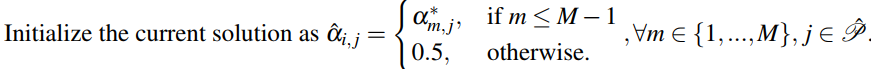

In [19]:
def Step1(attribute_num, alphas_res, M):
    
    alphas_pred = np.zeros(shape=(M, attribute_num))
    
    for i in range(0, M - 1):
        for j in range(0, attribute_num):
            alphas_pred[i][j] = alphas_res[i][j]
            
    for j in range(0, attribute_num):
        alphas_pred[M - 1][j] = 0.5
        
    return alphas_pred

STEP 2:
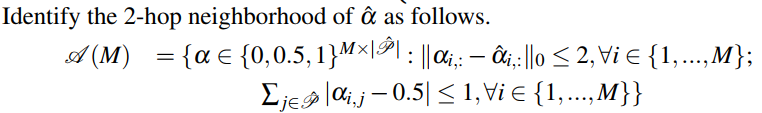

In [20]:
def check_neighborhood(alpha):
    if (np.abs(alpha - 0.5).sum() <= 1):
        return True
    return False

def valid_elements(x):
    if (x == 0.5):
        return 0, 1
    elif (x == 1):
        return 0, 0.5 
    return 0.5, 1

def d_hop_neighborood(alpha_set, alpha, d, start):
    
    if (d == 0):
        if (check_neighborhood(alpha)):
            alpha_set.append(alpha)
        return 
    
    if (len(alpha) - start < d):
        return 
    
    for i in range(start, len(alpha)):
        a, b = valid_elements(alpha[i])
        
        new_alpha1 = np.array(alpha) 
        new_alpha2 = np.array(alpha)
        
        new_alpha1[i] = a 
        new_alpha2[i] = b
        
        d_hop_neighborood(alpha_set, new_alpha1, d - 1, i + 1)
        d_hop_neighborood(alpha_set, new_alpha2, d - 1, i + 1)

def neighbors_generation(cur_neighbor, M, id, alpha_sets, neighbor_set):
    
    if (id == M):
        neighbor_set.append(np.array(cur_neighbor))
        return

    for alpha in alpha_sets[id]:
        
        new_neighbor = initialize(cur_neighbor)
        new_neighbor.append(alpha)
        neighbors_generation(cur_neighbor=new_neighbor, M=M, id=(id + 1), alpha_sets=alpha_sets, neighbor_set=neighbor_set)

def Step2(alphas_pred, M, attribute_num):
    
    alpha_sets = []
    
    for alpha in alphas_pred:
        
        new_alpha = np.array(alpha)
        alpha_set = []
        
        for d in range(0, 3):
            d_hop_neighborood(alpha_set=alpha_set, alpha=new_alpha, d=d, start=0)
            
        alpha_sets.append(alpha_set)
    
    neighbor_set = []
        
    neighbors_generation(cur_neighbor=[], M=M, id=0, alpha_sets=alpha_sets, neighbor_set=neighbor_set)
    
    return neighbor_set      

EVALUATE:
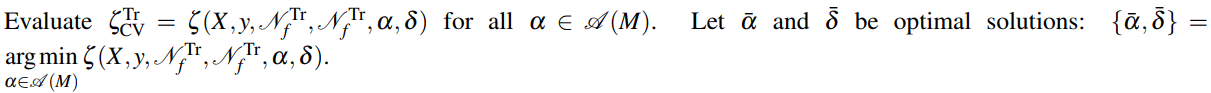

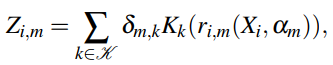

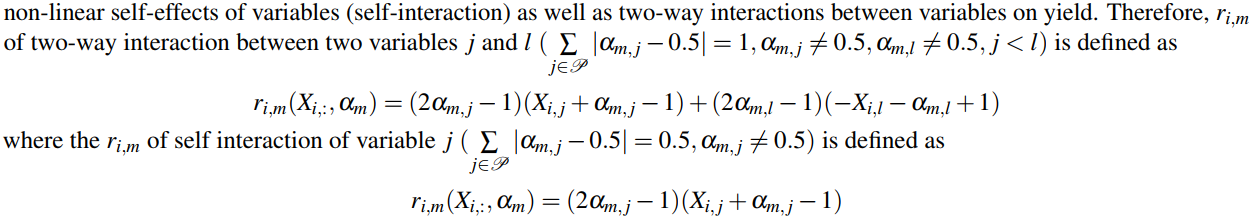

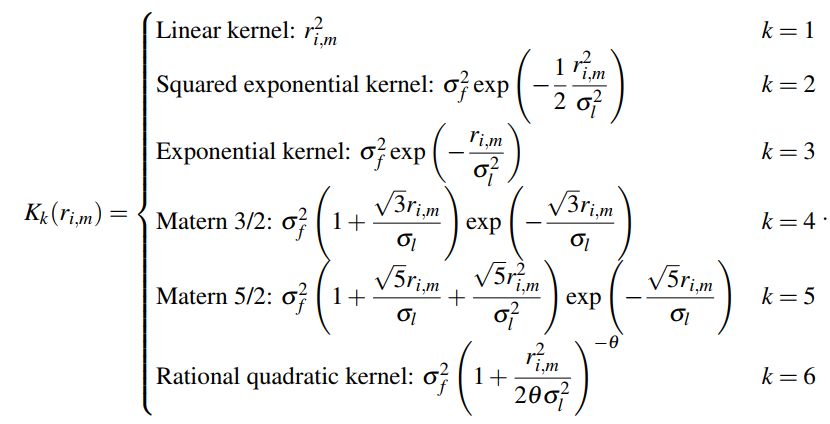

In [21]:
sigma_f = 0.5
sigma_l = 0.5
theta = 0.5

def linear(r):
    return r ** 2

def exponential(coef, r):
    #coef = 1 -> Exponential kernel
    #coef = 2 -> Squared exponential kernel
    return (sigma_f ** 2) * np.exp(-1 * (1 / coef) *  (r ** coef) / (sigma_l ** 2))

def matern(coef, r):
    #coef = 3 -> matern 3/2
    #coef = 5 -> matern 5/2
    if (coef == 3):
        return (sigma_f ** 2) * (1 + np.sqrt(3) * r / sigma_l) * np.exp(-1 * np.sqrt(3) * r / sigma_l)
    
    return (sigma_f ** 2) * (1 + np.sqrt(5) * r / sigma_l + np.sqrt(5) * (r ** 2) / (sigma_l ** 2)) * np.exp(-1 * np.sqrt(5) * r / sigma_l)

def quadratic(r):
    return (sigma_f ** 2) * (1 + (r ** 2) / (2 * theta * (sigma_l ** 2)))

def kernel_functions(r):
    
    return np.array([linear(r), exponential(1, r), exponential(2, r), matern(3, r), matern(5, r), quadratic(r)])


In [22]:
def interaction_type(sample, alpha):
    
    if (np.abs(alpha - 0.5).sum() > 1):
        print('Exception in alpha when there are more than 2 elements that are not 0.5')
        
    index = []
    
    for i in range(0, len(alpha)):
        if (alpha[i] != 0.5):
            index.append(i)
    
    r = 0

    if (len(index) == 2):
        j = index[0]
        l = index[1]
        r = (2 * alpha[j] - 1) * (sample[j] + alpha[j] - 1) + (2 * alpha[l] - 1) * (-sample[l] - alpha[l] + 1)
    else:
        j = index[0]
        r = (2 * alpha[j] - 1) * (sample[j] + alpha[j] - 1)
    
    return r
        

def interactions(X, alphas, deltas):
    
    interactions_matrix = []
    
    for sample in X:
        
        row = []
        
        for (m, alpha) in enumerate(alphas):
            
            if (np.abs(alpha - 0.5).sum() == 0):
                continue
            
            r = interaction_type(sample=sample, alpha=alpha)
            
            row.append(np.dot(deltas[m], kernel_functions(r)))

        interactions_matrix.append(row)
    
    return interactions_matrix

def combination(X, interactions_matrix):
    
    X_transformed = initialize(X)
    
    for i, sample in enumerate(X_transformed):
        if (len(interactions_matrix[i]) != 0):
            sample += interactions_matrix[i]
    
    return X_transformed
            

def RMSE(X_train, y_train, X_validation, y_validation, alphas, deltas):
    
    X_train_transformed = X_train.to_numpy()
    X_validation_transformed = X_validation.to_numpy()
    
    if (len(alphas) != 0):
        X_train_transformed = combination(X=X_train_transformed, interactions_matrix=interactions(X=X_train_transformed, alphas=alphas, deltas=deltas))
        X_validation_transformed = combination(X=X_validation_transformed, interactions_matrix=interactions(X=X_validation_transformed, alphas=alphas, deltas=deltas))
    
    linear_model = LinearRegression().fit(X_train_transformed, y_train)
    
    RMSE_train = root_mean_squared_error(y_true=y_train, y_pred=linear_model.predict(X_train_transformed))
    RMSE_validation = root_mean_squared_error(y_true=y_validation, y_pred=linear_model.predict(X_validation_transformed))
    
    return RMSE_train, RMSE_validation

def RMSE_FOLDS(scaled_folds, alphas, deltas, selected_features):
    
    RMSE_train_avg = 0
    RMSE_validation_avg = 0
    
    for fold in scaled_folds:
        X_train, X_validation, y_train, y_validation = split_train_test(fold)
        X_train_reduced = X_train[selected_features]
        X_validation_reduced = X_validation[selected_features]
        
        RMSE_train_cur, RMSE_validation_cur = RMSE(X_train_reduced, y_train, X_validation_reduced, y_validation, alphas=alphas, deltas=deltas)
        
        RMSE_train_avg += RMSE_train_cur
        RMSE_validation_avg += RMSE_validation_cur 
        
    return RMSE_train_avg/len(scaled_folds), RMSE_validation_avg/len(scaled_folds)
        
        

In [23]:
def Evaluate(scaled_folds, neighbor_set, deltas_set, selected_features):
    
    alphas_d = []
    deltas_d = []
    
    RMSE_min = 999999999
    
    for alphas in neighbor_set:
        for deltas in deltas_set:
            
            RMSE_cur = RMSE_FOLDS(scaled_folds=scaled_folds, alphas=alphas, deltas=deltas, selected_features=selected_features)[0]
            
            if (RMSE_cur < RMSE_min):
                RMSE_min = RMSE_cur
                alphas_d = alphas
                deltas_d = deltas 
    
    return alphas_d, deltas_d

In [24]:
def deltas_generation(deltas_set, deltas_cur, id, M, K):
    
    if (id == M):
        deltas_set.append(deltas_cur)
        return 
    
    for j in range(0, K):
        new_deltas = np.array(deltas_cur)
        
        new_deltas[id][j] = 1
        
        deltas_generation(deltas_set, new_deltas, id + 1, M, K)

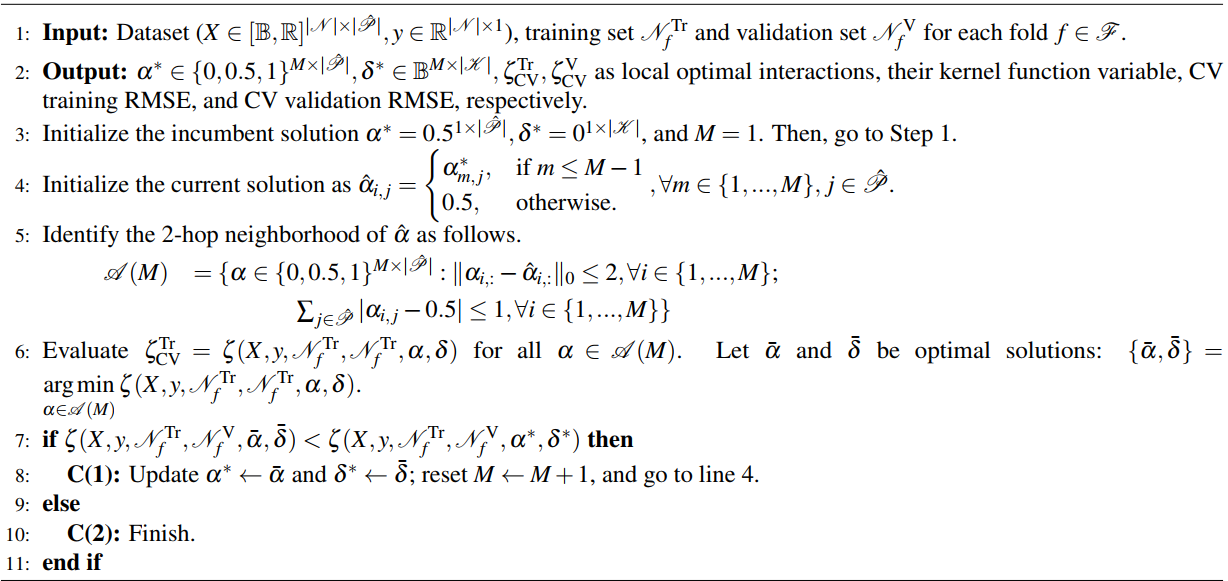

In [25]:
#folds: It has got 3 items, each item consists of 4 parts: X_train, X_test, y_train and y_test
#selected_features: a set of common features among 3 set of selected features which are determined from each fold by Elastic Net
#K: number of choosen kernel functions
def heuristic_interaction_detection(scaled_folds, selected_features, K):
    
    attribute_num = len(selected_features)
    
    alphas_res, deltas_res, M = Step0(attribute_num=attribute_num, K=K)

    while(True):
        alphas_pred = Step1(attribute_num=attribute_num, alphas_res=alphas_res, M=M)

        neighbor_set = Step2(alphas_pred=alphas_pred, M=M, attribute_num=attribute_num)
    
        deltas_set = []
        deltas_generation(deltas_set=deltas_set, deltas_cur=np.zeros((M, K)), id=0, M=M, K=K)
    
        alphas_d, deltas_d = Evaluate(scaled_folds=scaled_folds, neighbor_set=neighbor_set, deltas_set=deltas_set, selected_features=selected_features)
    
        if (RMSE_FOLDS(scaled_folds=scaled_folds, alphas=alphas_d, deltas=deltas_d, selected_features=selected_features)[1] < 
        RMSE_FOLDS(scaled_folds=scaled_folds, alphas=alphas_res, deltas=deltas_res, selected_features=selected_features)[1]):
            alphas_res = alphas_d
            deltas_res = deltas_d
            M = M + 1
        else:
            break
    
    return alphas_res, deltas_res   

In [26]:
scaled_folds = splitting_data(is_scaled=True)
K = 6
selected_features = ['Eva_V', 'Eva_VII', 'Eva_VIII', 'Eva_X', 'Eva_XI', 'Eva_XII', 'Prcp_II', 'Prcp_III', 'Prcp_V', 'Prcp_VI', 'Prcp_VII', 'Prcp_VIII', 'Prcp_IX', 'Prcp_X', 'Prcp_XI', 'Prcp_XII', 'Prcp_max_I', 'Prcp_max_III', 'Prcp_max_IV', 'Prcp_max_V', 'Prcp_max_VI', 'Prcp_max_VII', 'Prcp_max_IX', 'Prcp_max_X', 'Prcp_max_XI', 'Prcp_max_XII', 'Rdays_IV', 'Havg_II', 'Havg_III', 'Havg_VI', 'Havg_VIII', 'Hmin_V', 'Hmin_VI', 'Hmin_VII', 'Hmin_IX', 'Hmin_XII', 'Shours_II', 'Shours_III', 'Shours_IV', 'Shours_V', 'Shours_VI', 'Shours_VII', 'Shours_VIII', 'Shours_XII']

alphas_res, deltas_res = heuristic_interaction_detection(scaled_folds=scaled_folds, selected_features=selected_features, K=K)


1.3245538083126167 2.6792945137216306
